# Comparative Analysis of Sentiment Analysis Techniques

In this project, we will draw comparisons between traditional statistical analysis tools and cutting-edge AI/ML models. This notebook will examine of the capabilities of SAS against models such as the BERT transformer and LSTM (Long Short-Term Memory) networks.

## Objective

The primary aim is to evaluate and contrast the effectiveness of each method in classifying sentiments expressed in a dataset composed of various tweets. This evaluation will focus on metrics such as accuracy, recall, and precision scores to evaluate each method's performance.

## Approach

1. Create "Gold Standard" testing dataset in TestDaya.ipynb.
2. Import in Tweet Sentiment Extraction train.csv data.
3. Perform Necessary pre-processing.
4. Train a BERT Model and an LSTM Neural Network Model.
5. Test accuracy, precision, and recall on the "Gold Standard" dataset.
6. Analyze results. Explain why one model may work better than others and discuss interpretation of sarcasm and other figurative speech. 

If you are curious about the creation of the Gold Standard dataset, see the file "TestData.ipynb". I will start by importing the necessary libraries and defining necessary functions. 

In [230]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji
import string

from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
# import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np 
import pickle
import os


In [231]:
##Function to clean the data.
def preprocess(textdata , wordLemm):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()       
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

## Step 2

Now I will now read in the training data and display some basic information about it.

In [232]:
MultiClassTrain = pd.read_csv('Data/TweetSentimentExtraction.csv', encoding='utf-8')
# Display info
print(f"Num rows: {MultiClassTrain.shape[0]}")
MultiClassTrain.head()

Num rows: 27481


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [233]:
MultiClassTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


We have one null Value in the training data lets drop it

In [234]:
MultiClassTrain.dropna(inplace=True)

In [235]:
MultiClassTrain.describe()


,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [236]:
MultiClassTrain = MultiClassTrain.drop(['textID', 'selected_text'], axis=1)

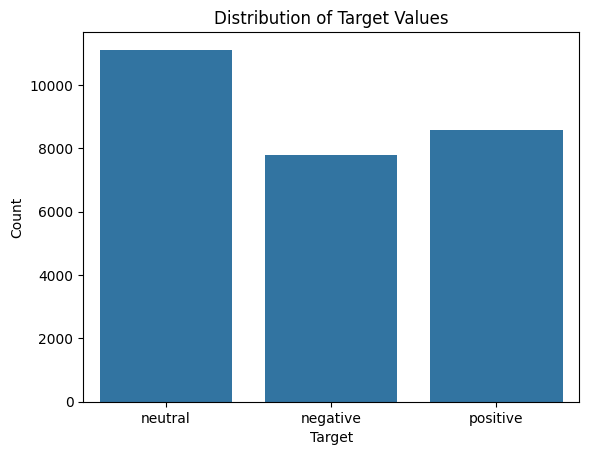

In [237]:
# Plotting the distribution 
sns.countplot(x='sentiment', data=MultiClassTrain)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## Step 3

Now I will prerform preprocessing of the data. 

In [238]:
# Function to replace emojis in text with their textual representations
#   Input: String representing a tweet text
#   Output: De-Emojied String
def convert_emoji(text):
    # Use the 'demojize' function from the emoji library
    return emoji.demojize(text, delimiters=("", ""))

#Remove punctuations, links, mentions
def strip_all_entities(text): 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [239]:
texts_new = []
for t in MultiClassTrain.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(convert_emoji(t))))))

MultiClassTrain["cleaned_text"] = texts_new

MultiClassTrain["cleaned_text"].head()


0                    Id have responded if I were going
1           Sooo SAD I will miss you here in San Diego
2                               my boss is bullying me
3                        what interview leave me alone
4    Sons of why couldnt they put them on the relea...
Name: cleaned_text, dtype: object

/var/folders/rv/z62fqs510zbc9txn4llltg380000gn/T/ipykernel_38484/1238840584.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=MultiClassTrain[MultiClassTrain['text_len']<5], palette='mako')


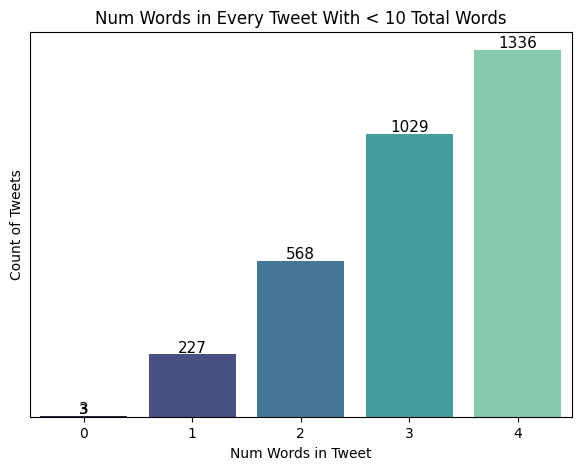

3163


In [240]:
text_len = []
for text in MultiClassTrain.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

MultiClassTrain['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=MultiClassTrain[MultiClassTrain['text_len']<5], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
# Annotating each bar with its respective count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.ylabel('Count of Tweets')
plt.xlabel('Num Words in Tweet')
plt.title('Num Words in Every Tweet With < 10 Total Words')
plt.show()

print(MultiClassTrain[MultiClassTrain['text_len']<5].shape[0])


In [241]:
# wordLemm = WordNetLemmatizer()
# processedtext = preprocess(text , wordLemm)

## set containing all stopwords.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

First I will try to train a bert model

Tokenizing: 100%|██████████| 27480/27480 [00:03<00:00, 7222.43it/s]


Token count over 800: 0


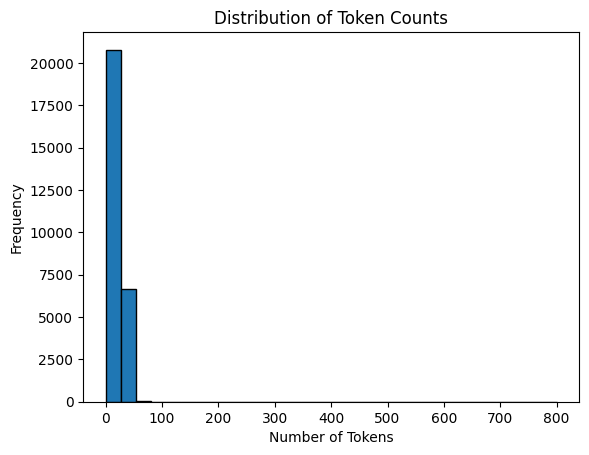

Average token count (for texts with <= 800 tokens): 18.71353711790393
Train Data Average BERT token count: 18.71353711790393





In [242]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Config stuff
encode_data = False
save_encoding = False
find_token_averages = True

def token_distribution(texts):
    # Tokenize each text and count the tokens, with tqdm for progress tracking
    token_counts = [len(tokenizer.tokenize(text)) for text in tqdm(texts, desc="Tokenizing")]

    # Filter out token counts greater than 800 and print them
    excessive_tokens = [count for count in token_counts if count > 800]
    print(f"Token count over 800: {len(excessive_tokens)}")
    
    # Limit the histogram to token counts of 800 or less
    limited_token_counts = [count for count in token_counts if count <= 800]
    
    # Plot the distribution of token counts up to 800
    plt.hist(limited_token_counts, bins=30, range=(0,800), edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Counts')
    plt.show()
    
    # Calculate the average token count excluding the counts over 800
    average_token_count = sum(limited_token_counts) / len(limited_token_counts) if limited_token_counts else 0
    print(f"Average token count (for texts with <= 800 tokens): {average_token_count}")
    
    # Return the average token count for texts with 800 tokens or less
    return average_token_count

# Assuming 'train_data' and 'test_data' are defined and have a 'Lyrics' column
if 'find_token_averages' in locals() and find_token_averages:
    average_length_in_tokens = token_distribution(MultiClassTrain['text'].tolist())
    print(f"Train Data Average BERT token count: {average_length_in_tokens}")
    print("\n\n")
    # average_length_in_tokens = token_distribution(test_data['Lyrics'].tolist())
    # print(f"Test Data Average BERT token count: {average_length_in_tokens}")